In [92]:
import os
import pickle
import sys

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import math
import numpy as np
import scipy
from Functions import renormalize, scomplex, plotting, support
import matplotlib.pyplot as plt
from scipy.stats import entropy as sp_entropy
import networkx as nx
import sklearn
from sklearn import cluster
import seaborn as sns
import powerlaw as pwl
plt.rcParams["text.usetex"] = True

import matplotlib.colors as mcolors
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib.colors import LinearSegmentedColormap

#colors = list(mcolors.CSS4_COLORS)
#colors = colors + colors
colors = ["#071C56","#06418F","#2B589F","#5A5389","#7F588D","#533262","#B45389","#D75F78","#FDA599","#A40237"]
colors = colors + colors + colors + colors 
cmap = LinearSegmentedColormap.from_list("my_sas",colors)


In [124]:
# Triangle Tree
edges = [(0,1),(1,2),(0,2)]
new_boundary = [0,1,2]
n = 3
steps = 4
for s in range(steps):
    boundary = new_boundary
    new_boundary = []
    for node in boundary:
        new_boundary.append(n)
        new_boundary.append(n+1)
        edges.append((node,n))
        edges.append((node,n+1))
        edges.append((n,n+1))
        n += 2
G = nx.from_edgelist(edges)

In [75]:
# Tetrahedron tree attach through edges
edges = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
new_boundary = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
n = 4
steps = 3
for s in range(steps):
    #boundary = new_boundary
    #new_boundary = []
    boundary = edges.copy()
    for ed in boundary:
        edges.append((ed[0],n))
        edges.append((ed[0],n+1))
        edges.append((ed[1],n))
        edges.append((ed[1],n+1))
        edges.append((n,n+1))
        #new_boundary.append((ed[0],n))
        #new_boundary.append((ed[0],n+1))
        #new_boundary.append((ed[1],n))
        #new_boundary.append((ed[1],n+1))
        #new_boundary.append((n,n+1))
        n += 2
G = nx.from_edgelist(edges)

In [89]:
# Pseudofractal
edges = [(0,1),(1,2),(0,2)]
n = 3
steps = 6
for s in range(steps):
    boundary = edges.copy()
    for ed in boundary:
        edges.append((ed[0],n))
        edges.append((ed[1],n))
        n += 1

G = nx.from_edgelist(edges)


In [138]:
# Triangle Tree 2
edges = [(0,1),(1,2),(0,2)]
new_boundary = edges.copy()
n = 3
steps = 3
for s in range(steps):
    boundary = new_boundary
    new_boundary = []
    for ed in boundary:
        edges.append((ed[0],n))
        edges.append((ed[1],n))
        new_boundary.append((ed[0],n))
        new_boundary.append((ed[1],n))
        n += 1

G = nx.from_edgelist(edges)


In [93]:
# C. Elegans
f = open("CaenorhabditisElegans_lcb_hq.txt","r")
i = 0
edges = []
for line in f:
    if i != 0:
        words = line.split()
        edges.append((words[0],words[1]))
    else:
        i += 1
f.close()
G = nx.from_edgelist(edges)
G = nx.convert_node_labels_to_integers(G)
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

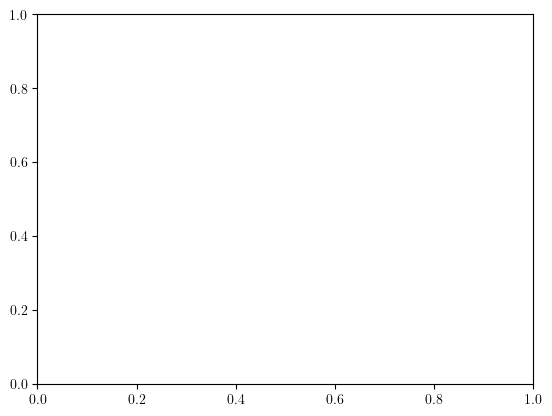

In [109]:

#G = nx.dorogovtsev_goltsev_mendes_graph(4)
#G = nx.random_tree(200, seed=10)
#G = nx.stochastic_block_model([40,40],[[0.3,0.02],[0.02,0.3]])

#G = nx.from_edgelist(edges)
#sc = scomplex.convert_graph_to_sc(G)

#sc  = scomplex.generate_fractal_cycle([20,40,60,5],0.0,20)
#sc = scomplex.generate_hlattice(12,12,0)
sc = scomplex.NGF(2,500,1,1)
#sc = scomplex.generate_bridged_communities(50,50,0.04,0.04,10)

B1, B2, B3, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(sc)

if np.min(B2.shape) > 0:
    assert(np.max(np.abs(B1@B2)) == 0)
if np.min(B3.shape) > 0:
    assert(np.max(np.abs(B2@B3)) == 0)
assert(np.max(np.abs(np.sum(B1,0))) == 0)

f,ax = plt.subplots(1,1)
#plotting.plot_complex(sc,ax = ax,face_color=[colors[3]],layout = "spring", node_size=20)


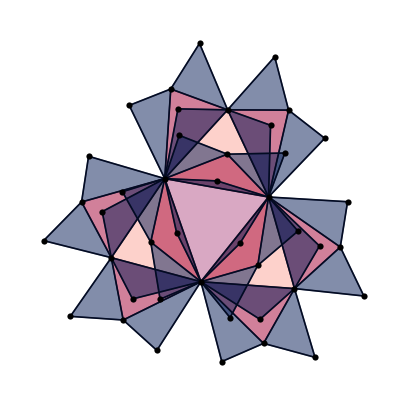

In [55]:
fcolors = []
for i in range(sc["n2"]):
    fcolors.append(colors[1*int(np.floor(math.log(sc["faces"][i,2]*2/3-1,3)))+8])
f,ax = plt.subplots(1,1,figsize = (5,5))
plotting.plot_complex(sc,ax = ax, face_color= fcolors,layout = "spring", edge_color=[0.4/255*np.array(tuple(int(colors[0].lstrip("#")[j:j+2], 16) for j in (0, 2, 4)))],node_size=20,edge_width=1.2,face_alpha = 0.5)
ax = plt.gca() # to get the current axis
ax.collections[0].set_linewidth(0) 
ax.collections[0].set_edgecolor("#FFFFFF") 
#plt.savefig('pseudofracta_complex.pdf')

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


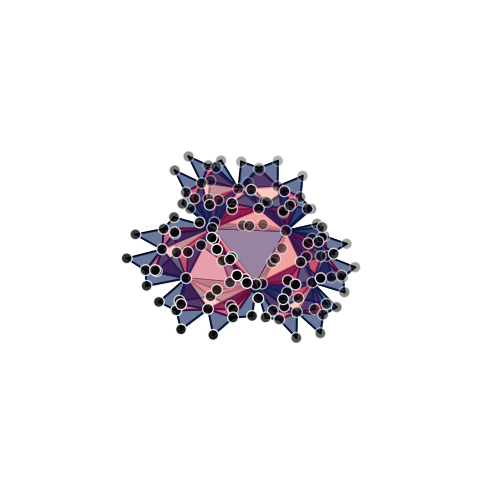

In [6]:
#%matplotlib widget

# 3d spring layout
G = nx.Graph()
G.add_edges_from(sc["edges"])
pos = nx.spring_layout(G, dim=3, seed = 88, iterations =5000)
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection="3d")


fcolors = []
for i in range(sc["n2"]):
    fcolors.append(colors[1*int(np.floor(math.log(sc["faces"][i,2]*2/3-1,3)))+7])

for i in range(sc["n2"]):
            f = sc["faces"][i, :]
            x = [node_xyz[f[0]][0], node_xyz[f[1]][0], node_xyz[f[2]][0]]
            y = [node_xyz[f[0]][1], node_xyz[f[1]][1], node_xyz[f[2]][1]]
            z = [node_xyz[f[0]][2], node_xyz[f[1]][2], node_xyz[f[2]][2]]
            #poly = PolyCollection([x,y,z], facecolors="tab:red", alpha=.7)
            #ax.add_collection3d(poly, zs = 1, zdir='y')
            verts = [[[xx,yy,zz] for xx,yy,zz in zip(x,y,z)]]    # NEW
            ax.add_collection3d(Poly3DCollection(verts,alpha = 0.6,color = fcolors[i]))

# # Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="black", linewidth = 1.3)


# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=60, ec="w",color = "black")
#ax.collections[0].set_linewidth(0.001) 

ax.set_axis_off()
# ax.set_xlim(xmin=np.min(x)-1,xmax=np.max(x)+1)
# ax.set_ylim(ymin=np.min(y)-1,ymax=np.max(y)+1)
# ax.set_zlim(zmin=np.min(z)-1,zmax=np.max(z)+1)

plt.show()

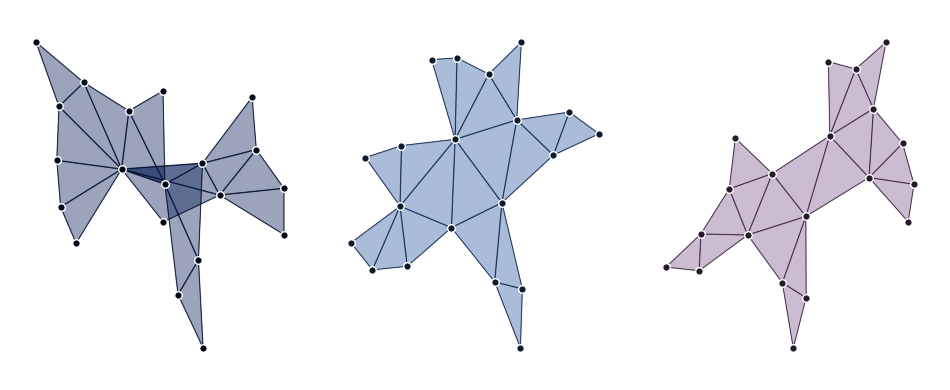

In [148]:
f,ax = plt.subplots(1,3,figsize = (16/5*3,4))
for i in range(3):
    sc = scomplex.NGF(2,20,-1,0.3)
    plotting.plot_complex(sc,ax = ax[i], face_color=[colors[2*i]], edge_color=[0.3/255*np.array(tuple(int(colors[2*i].lstrip("#")[j:j+2], 16) for j in (0, 2, 4)))], node_color=[0.3/255*np.array(tuple(int(colors[2*i].lstrip("#")[j:j+2], 16) for j in (0, 2, 4)))],layout = "spring", iterations = 10000,node_size=30,edge_width=0.5,face_alpha = 0.4)
    ax[i].collections[0].set_edgecolor("#FFFFFF") 

plt.tight_layout()
#plt.savefig('DGM.png', transparent=True)

In [110]:
names = ["$L_0$","$L_1^{d}$","$L_1^{u}$","$L_1$","$\mathcal{L}_1^d$","$\mathcal{L}_1^u$","$\mathcal{L}_1$","$\mathcal{L}_1^d + \mathcal{L}_1^u$","$L_2$","$\mathcal{L}_2$"]

L0 = (B1@B1.T).todense()

L1d = (B1.T@B1).todense()
L1dR = -np.abs(L1d - np.diag(np.diag(L1d))) + np.diag(np.array(np.sum(np.abs(L1d - np.diag(np.diag(L1d))),0))[0])

L1u = (B2@B2.T).todense()
L1uR = -np.abs(L1u - np.diag(np.diag(L1u))) + np.diag(np.array(np.sum(np.abs(L1u - np.diag(np.diag(L1u))),0))[0])

L1tot = (B2@B2.T + B1.T@B1).todense()
L1totR = -np.abs(L1tot - np.diag(np.diag(L1tot))) + np.diag(np.array(np.sum(np.abs(L1tot - np.diag(np.diag(L1tot))),0))[0])

L2 = (B2.T@B2 + B3@B3.T).todense()
L2R = -np.abs(L2 - np.diag(np.diag(L2))) + np.diag(np.array(np.sum(np.abs(L2 - np.diag(np.diag(L2))),0))[0])
Laplacians = [L0,L1d,L1u,L1tot,L1dR,L1uR,L1totR,L1uR+L1dR,L2,L2R]

eigs = []
sp_heats = []
for i in range(len(Laplacians)):
    L1 = Laplacians[i]
    D1,U1 = np.linalg.eigh(L1)
    specific_heat1,tau_space, __ = renormalize.compute_heat(D1,-2,4,200)
    sp_heats.append(specific_heat1)
    eigs.append(D1)

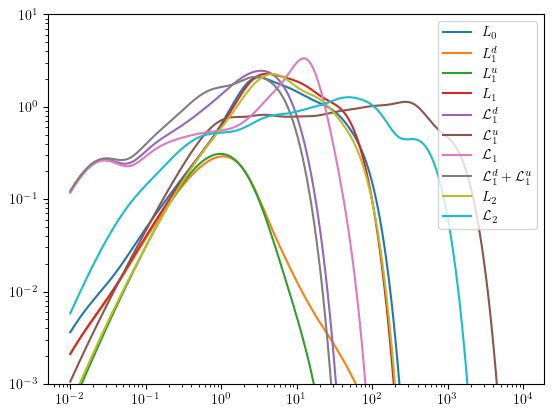

In [111]:
for i in range(len(Laplacians)):
    plt.loglog(tau_space,sp_heats[i])
plt.ylim([10**-3,10])
plt.legend(names)
#plt.savefig('DGM_curves.png')

In [105]:
nrep = 1
sp_heats = [np.zeros(149),np.zeros(149),np.zeros(149),np.zeros(149),np.zeros(149)]
for r in range(nrep):
    print(r)
    #sc = scomplex.NGF(2,400,1,0.6)
    #G = nx.dorogovtsev_goltsev_mendes_graph(6)
    #sc = scomplex.convert_graph_to_sc(G)
    B1, B2, B3, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(sc)
    L0 = (B1@B1.T).todense()
    L1d = (B1.T@B1).todense()
    L1u = (B2@B2.T).todense()
    L1 = L1d + L1u
    L2 = (B2.T@B2).todense()
    L1dR = -np.abs(L1d - np.diag(np.diag(L1d))) + np.diag(np.array(np.sum(np.abs(L1d - np.diag(np.diag(L1d))),0))[0])
    L1uR = -np.abs(L1u - np.diag(np.diag(L1u))) + np.diag(np.array(np.sum(np.abs(L1u - np.diag(np.diag(L1u))),0))[0])
    L1R = -np.abs(L1 - np.diag(np.diag(L1))) + np.diag(np.array(np.sum(np.abs(L1 - np.diag(np.diag(L1))),0))[0])
    L2R = -np.abs(L2 - np.diag(np.diag(L2))) + np.diag(np.array(np.sum(np.abs(L2 - np.diag(np.diag(L2))),0))[0])
    Laps = [L0,L1dR,L1uR,L1R,L2R]
    for i in range(5):
        speig,__ = np.linalg.eigh(Laps[i])
        spheat,tau_space, __ = renormalize.compute_heat(speig,-2,4,150)
        sp_heats[i] += spheat/nrep



#plt.legend([names[name] for name in selected])
#plt.savefig('DGM_curves.png')

0


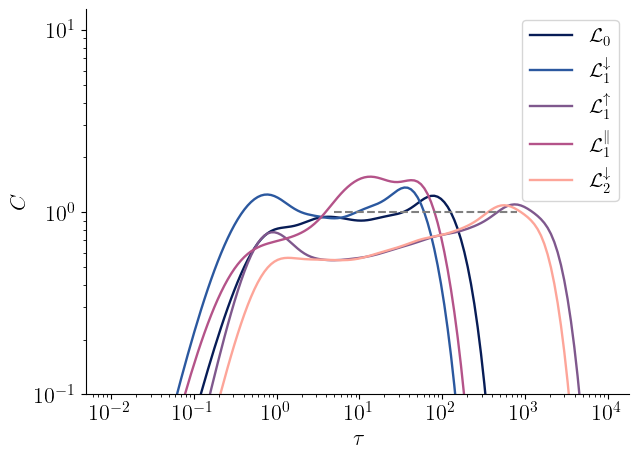

In [106]:
f,ax = plt.subplots(1,1,figsize = (7,5))
for i in range(5):
    ax.semilogx(tau_space,sp_heats[i],color = colors[int(np.floor(2*i))],linewidth = 1.7)
ax.set_yscale("log")
ax.set_ylim([10**-1,13])
ax.legend([r"$\mathcal{L}_0$",r"$\mathcal{L}_1^{\downarrow}$",r"$\mathcal{L}_1^{\uparrow}$",r"$\mathcal{L}^\parallel_1$",r"$\mathcal{L}^\downarrow_2$"],fontsize = 15)
ax.set_xlabel(r"$\tau$",fontsize = 16)
ax.set_ylabel(r"$C$",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hlines(y = 1,xmin=5,xmax = 800,linestyles='--',color = [0.5,0.5,0.5])
sns.despine()
#plt.savefig('pseudofractalDMG.pdf')

In [111]:
L1 = Laplacians[5]
D1,U1 = np.linalg.eigh(L1)
order = 1


399
sas


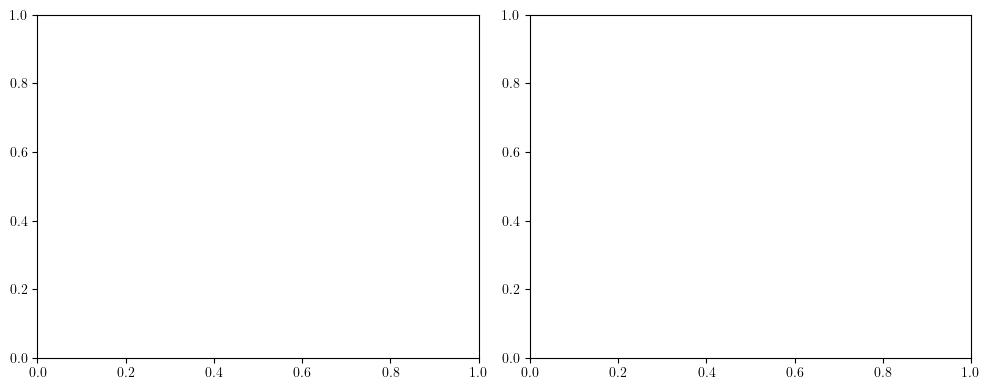

In [123]:
tau = 2

#rho  = np.abs(U1@np.diag(np.exp(-tau*D1))@U1.T)
rho = scipy.linalg.expm(-tau*L1)

Gv = nx.Graph()
Gv.add_nodes_from([i for i in range(sc[f"n{order}"])])
for i in range(sc[f"n{order}"]):
    for j in range(i+1,sc[f"n{order}"]):
        if rho[i,j] > min(rho[i,i],rho[j,j]):
            Gv.add_edge(i,j)


idx_components = {u:i for i,node_set in enumerate(nx.connected_components(Gv)) for u in node_set}
clusters = [idx_components[u] for u in Gv.nodes]

mapnodes,__ = renormalize.coarse_grain_interfaces(sc,order,clusters,np.max(clusters)+1)
new_sc = renormalize.induce_simplices(sc, mapnodes)
print(new_sc["n0"])

fig,axs = plt.subplots(1,2,figsize = (10,4))
if order == 0:
    print("sas")
    #plotting.plot_complex(sc,ax = axs[0], node_color = [colors[i] for i in clusters], node_size= 20)
elif order == 1:
    print("sas")
    #plotting.plot_complex(sc,ax = axs[0],edge_color = [(colors+colors)[i] for i in clusters], edge_width= 2)
elif order == 2:
    plotting.plot_complex(sc,ax = axs[0],face_color = [(colors+colors)[i] for i in clusters], edge_width = 0.5)

#plotting.plot_complex(new_sc,ax = axs[1],layout = "spring")
fig.tight_layout()
#plt.savefig('clusters_renorm.png', transparent=True)


In [124]:
B1n, B2n, __, __, r_edge_dict, r_face_dict, r_tet_dict = scomplex.boundary_matrices_3(new_sc)

r_L0 = (B1n@B1n.T).todense()

r_L1d = (B1n.T@B1n).todense()
r_L1dR = -np.abs(r_L1d - np.diag(np.diag(r_L1d))) + np.diag(np.array(np.sum(np.abs(r_L1d - np.diag(np.diag(r_L1d))),0))[0])

r_L1u = (B2n@B2n.T).todense()
r_L1uR = -np.abs(r_L1u - np.diag(np.diag(r_L1u))) + np.diag(np.array(np.sum(np.abs(r_L1u - np.diag(np.diag(r_L1u))),0))[0])

r_L1tot = (B2n@B2n.T + B1n.T@B1n).todense()
r_L1totR = -np.abs(r_L1tot - np.diag(np.diag(r_L1tot))) + np.diag(np.array(np.sum(np.abs(r_L1tot - np.diag(np.diag(r_L1tot))),0))[0])

r_L2 = (B2n.T@B2n).todense()
r_L2R = -np.abs(r_L2 - np.diag(np.diag(r_L2))) + np.diag(np.array(np.sum(np.abs(r_L2 - np.diag(np.diag(r_L2))),0))[0])
r_Laplacians = [r_L0,r_L1d,r_L1u,r_L1tot,r_L1dR,r_L1uR,r_L1totR,r_L1uR+r_L1dR, r_L2, r_L2R]


r_eigs = []
for i in range(len(r_Laplacians)):
    r_L1 = r_Laplacians[i]
    r_D1,_ = np.linalg.eigh(r_L1)
    r_eigs.append(r_D1)

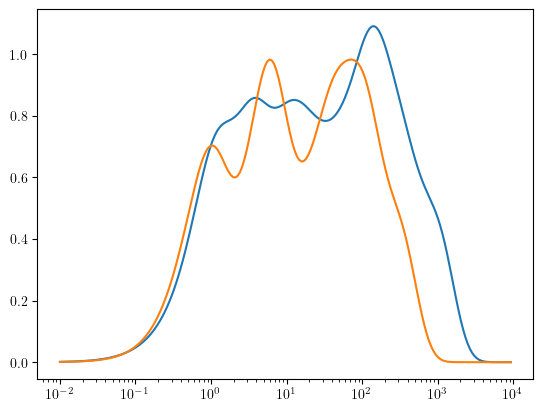

In [97]:
specific_heat1,tau_space, __ = renormalize.compute_heat(eigs[5],-2,4,200)
specific_heat1_r,tau_space, __ = renormalize.compute_heat(r_eigs[5],-2,4,200)
plt.semilogx(tau_space,specific_heat1)
plt.semilogx(tau_space,specific_heat1_r)

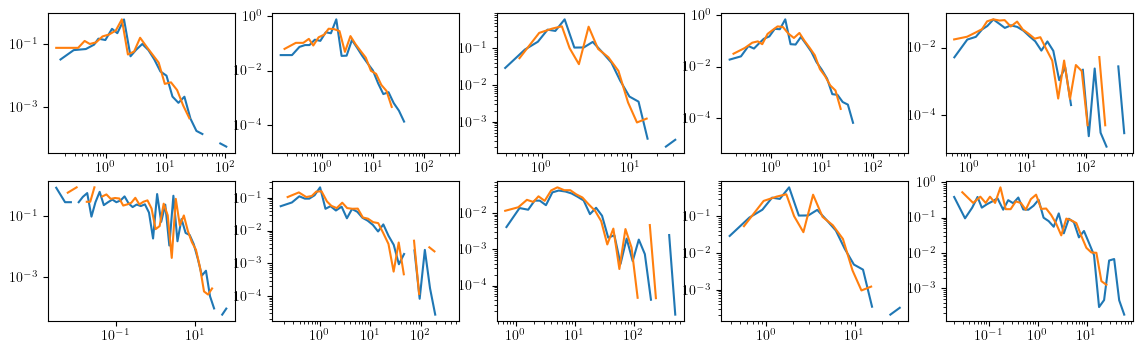

In [125]:
f,axs = plt.subplots(2,5,figsize = (14,4))
for i in range(len(r_Laplacians)):
    if i<5:
        ax = axs[0,i]
    else:
        ax = axs[1,i-5]
    pwl.plot_pdf(eigs[i][eigs[i]>10**-9],ax=ax)
    pwl.plot_pdf(r_eigs[i][r_eigs[i]>10**-9],ax=ax)

In [126]:
deg0 = scomplex.generalized_degree(sc, edge_dict, face_dict, tet_dict, 2)
deg = scomplex.generalized_degree(new_sc, r_edge_dict, r_face_dict, r_tet_dict, 2)

<AxesSubplot: >

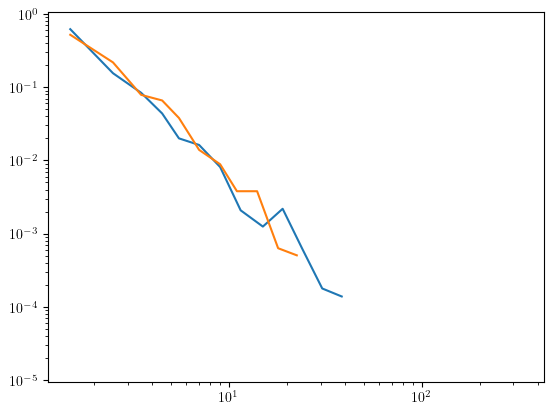

In [128]:
i = 0
pwl.plot_pdf(deg0[i])
pwl.plot_pdf(deg[i][deg[i]>0])

In [82]:
def renormalize_steps(sc,lmax,tau, order =1, PLOT = False, VERBOSE = False):
    B1n, B2n, __, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(sc)
    if PLOT:
        fig,axs = plt.subplots(1,lmax,figsize = (18/4*lmax,4.4))

    curvs = np.zeros((lmax))
    new_sc = sc
    for l in range(lmax):
        if l > 0 and new_sc["n0"]>1:
            B1n, B2n, __, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(new_sc)
            if order == 0:
                #L1new = (B1n@B1n.T).todense()
                L1new = (0*scomplex.laplacian_of_order(new_sc, 1) +  scomplex.laplacian_of_order(new_sc, 2)).todense()
                L1new = np.array((L1new - np.diag(np.diag(L1new))) != 0,dtype = int) 
                L1new = L1new + np.diag(np.sum(np.abs(L1new),0))
            elif order == 1:
                #L1new = (B1n.T@B1n).todense()
                L1new = (B2n@B2n.T).todense()
                #L1new = (B1n.T@B1n + B2n@B2n.T).todense()
                L1new = -np.abs(L1new - np.diag(np.diag(L1new))) + np.diag(np.array(np.sum(np.abs(L1new - np.diag(np.diag(L1new))),0))[0])
            elif order == 2:
                L1new = (B2n.T@B2n).todense()
                L1new = -np.abs(L1new - np.diag(np.diag(L1new))) + np.diag(np.array(np.sum(np.abs(L1new - np.diag(np.diag(L1new))),0))[0])

            D1new,U1new = np.linalg.eigh(L1new)

            rho  = np.abs(U1new@np.diag(np.exp(-tau*D1new))@U1new.T)
            Gv = nx.Graph()
            Gv.add_nodes_from([i for i in range(new_sc[f"n{order}"])])
            for i in range(new_sc[f"n{order}"]):
                for j in range(i+1,new_sc[f"n{order}"]):
                    if rho[i,j] >= min(rho[i,i],rho[j,j]):
                        Gv.add_edge(i,j)

                
            idx_components = {u:i for i,node_set in enumerate(nx.connected_components(Gv)) for u in node_set}
            clusters = [idx_components[u] for u in Gv.nodes]

            mapnodes,__ = renormalize.coarse_grain_interfaces(new_sc,order,clusters,np.max(clusters)+1)
            new_sc = renormalize.induce_simplices(new_sc, mapnodes)
            if VERBOSE:
                print(new_sc["n0"])

        if PLOT:
            #fcolors = []
            #for i in range(new_sc["n2"]):
            #    fcolors.append(colors[1*int(np.floor(math.log(new_sc["faces"][i,2]*2/3-1,3)))+7])

            plotting.plot_complex(new_sc,ax = axs[l], face_color=[colors[2*l]],edge_color=[0.4/255*np.array(tuple(int(colors[2*l].lstrip("#")[j:j+2], 16) for j in (0, 2, 4)))], node_color=[0.4/255*np.array(tuple(int(colors[2*l].lstrip("#")[j:j+2], 16) for j in (0, 2, 4)))],layout = "spring", iterations = 2000, node_size=4,edge_width=0.8,face_alpha = 0.4)
            #plotting.plot_complex(new_sc,ax = axs[l], face_color=fcolors,layout = "spring", node_size=4,edge_width=0.4+0.2*l,face_alpha = 0.45)
            
        L1tot = (B1n.T@B1n + B2n@B2n.T).todense()
        L1B = L1tot - np.diag(np.diag(L1tot)) + np.diag(np.array(np.sum(np.abs(L1tot - np.diag(np.diag(L1tot))),0))[0])
        F = L1tot - L1B
        curvs[l] = np.mean(F)
    
    if PLOT:
        plt.tight_layout()
        #plt.savefig('pseudofractal_steps.pdf')
        
    return curvs  

array([-0.08047554, -0.08047554, -0.08047554, -0.08047554])

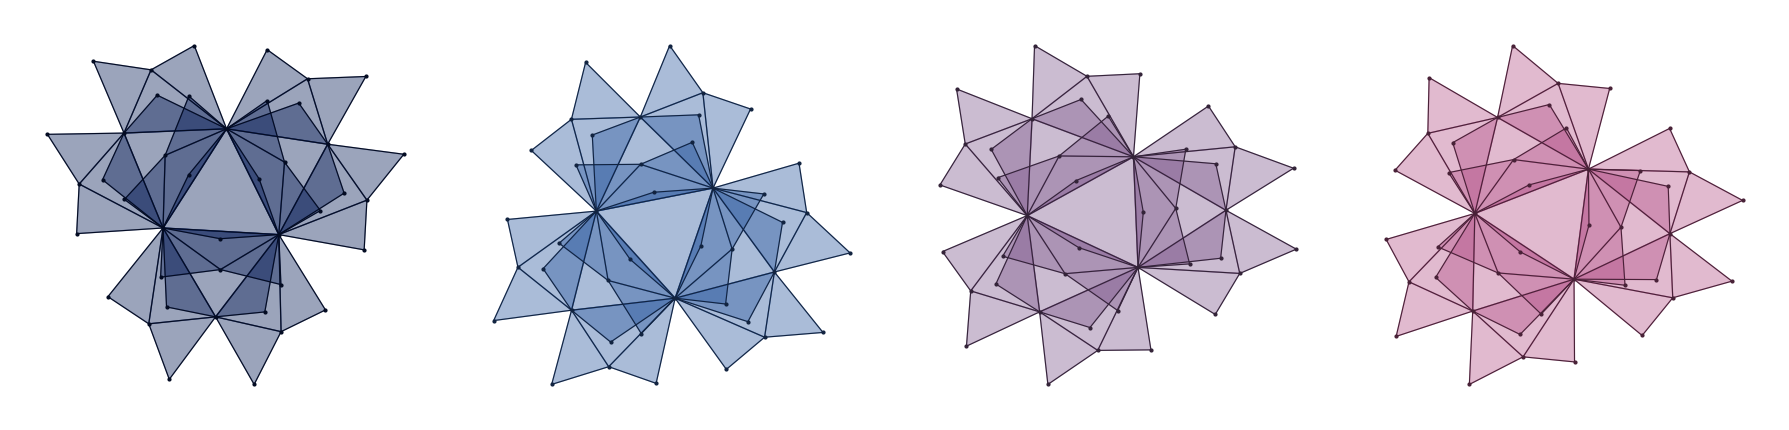

In [88]:
renormalize_steps(sc,4,tau = 0.26, order =0,PLOT = True)

In [79]:
L1new = (scomplex.laplacian_of_order(sc, 2)).todense()
L1new = -np.array((L1new - np.diag(np.diag(L1new))) != 0) 
L1new = L1new + np.diag(np.sum(np.abs(L1new),0))

TypeError: The numpy boolean negative, the `-` operator, is not supported, use the `~` operator or the logical_not function instead.

array([-0.05268506, -0.05268506, -0.08047554, -0.06995885])

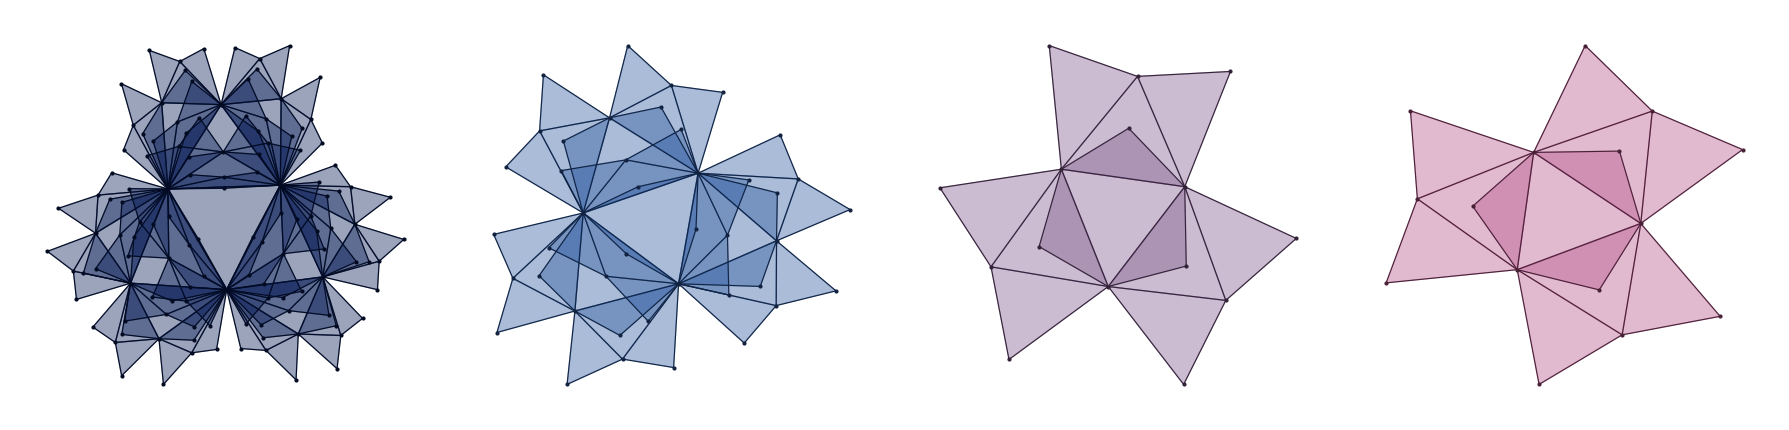

In [6]:
renormalize_steps(sc,4,2.3, order =1,PLOT = True)

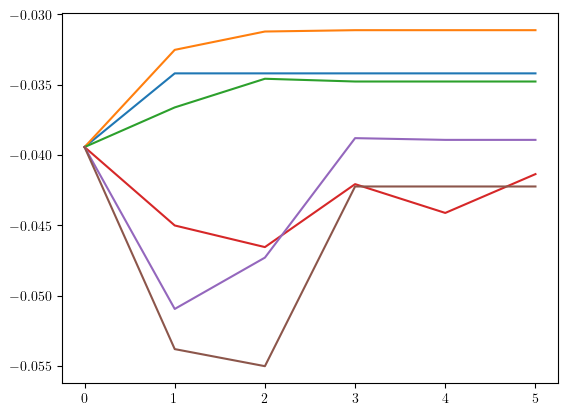

In [264]:
lmax = 7
tt = 0
order = 1
tau_space = np.linspace(0.3,4,6)
curvs = np.zeros((len(tau_space),lmax))
for i in range(len(tau_space)):
    curvs[i,:] = renormalize_steps(sc,lmax,tau_space[i], order =1)

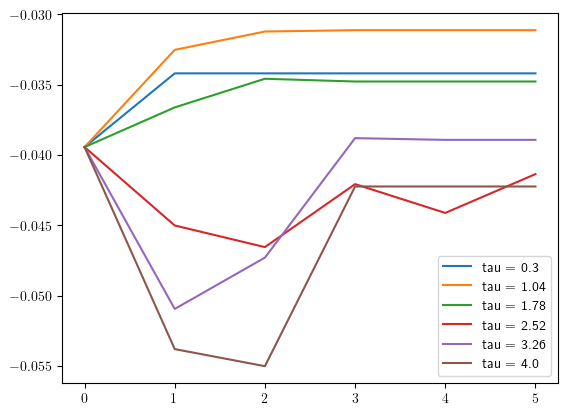

In [265]:
plt.plot(curvs[:,1:].T)
plt.legend(["tau = "+str(np.round(tau_space[i],2)) for i in range(len(tau_space))])


/Users/marconurisso/Desktop/Work/Simplicial_Renormalization/HodgeLaplacianRenorm/hodge_renormalization/Hodge_renorm/Experiments_setups/../Functions/renormalize.py:305: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


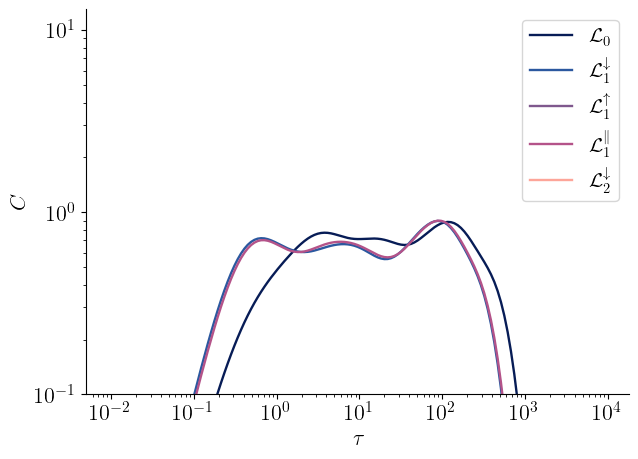

In [116]:
nrep = 1
sp_heats = [np.zeros(149),np.zeros(149),np.zeros(149),np.zeros(149),np.zeros(149)]
B1, B2, B3, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(new_sc)
L0 = (B1@B1.T).todense()
L1d = (B1.T@B1).todense()
L1u = (B2@B2.T).todense()
L1 = L1d + L1u
L2 = (B2.T@B2).todense()
L1dR = -np.abs(L1d - np.diag(np.diag(L1d))) + np.diag(np.array(np.sum(np.abs(L1d - np.diag(np.diag(L1d))),0))[0])
L1uR = -np.abs(L1u - np.diag(np.diag(L1u))) + np.diag(np.array(np.sum(np.abs(L1u - np.diag(np.diag(L1u))),0))[0])
L1R = -np.abs(L1 - np.diag(np.diag(L1))) + np.diag(np.array(np.sum(np.abs(L1 - np.diag(np.diag(L1))),0))[0])
L2R = -np.abs(L2 - np.diag(np.diag(L2))) + np.diag(np.array(np.sum(np.abs(L2 - np.diag(np.diag(L2))),0))[0])
Laps = [L0,L1dR,L1uR,L1R,L2R]
for i in range(5):
    speig,__ = np.linalg.eigh(Laps[i])
    spheat,tau_space, __ = renormalize.compute_heat(speig,-2,4,150)
    sp_heats[i] += spheat/nrep

f,ax = plt.subplots(1,1,figsize = (7,5))
for i in range(5):
    ax.semilogx(tau_space,sp_heats[i],color = colors[int(np.floor(2*i))],linewidth = 1.7)
ax.set_yscale("log")
ax.set_ylim([10**-1,13])
ax.legend([r"$\mathcal{L}_0$",r"$\mathcal{L}_1^{\downarrow}$",r"$\mathcal{L}_1^{\uparrow}$",r"$\mathcal{L}^\parallel_1$",r"$\mathcal{L}^\downarrow_2$"],fontsize = 15)
ax.set_xlabel(r"$\tau$",fontsize = 16)
ax.set_ylabel(r"$C$",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#ax.hlines(y = 1,xmin=5,xmax = 800,linestyles='--',color = [0.5,0.5,0.5])
sns.despine()
#plt.savefig('pseudofractalDMG.pdf')